In [1]:
'''fixed factor is normalizing the spectral density'''
'''the spectral density is computed separately along each axis'''
'''in this version we always use the same image (times batch size), 
substract batch average at each step to obtain batch-wise advantages
use reward with axes of fft being separated'''

'in this version we always use the same image (times batch size), \nsubstract batch average at each step to obtain batch-wise advantages\nuse reward with axes of fft being separated'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


config:  namespace(action_upper_bound=array([2., 2.]), batch_size=32, distance_penalty_coefficient=0.1, distance_penalty_enabled=False, distance_penalty_exponent=2, distance_penalty_r0=15.0, do_grayscale=True, filter=array([[[[ 0.        ],
         [ 1.        ],
         [ 0.93406058],
         [ 0.16910922],
         [-0.25916066],
         [-0.38278056],
         [-0.36833901],
         [-0.306479  ],
         [-0.23612829],
         [-0.17285442],
         [-0.12178184],
         [-0.08322866],
         [-0.05547789],
         [-0.03621425],
         [-0.02322227],
         [-0.01466442]]]]), fixed_image_num=1, fixed_spectral_density_normalization=1000000.0, foveate=None, gym_mode=False, history_length=16, image_h=224, image_hm=264, image_w=224, image_wm=264, loud=True, margin=20, max_freq=13, min_freq=1, motion_mode='velocity', normalize_spectral_density_per_step=False, sum_axes=False, t_ignore=16, t_max=50, use_dones=False)


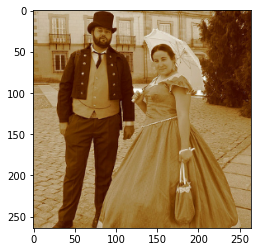

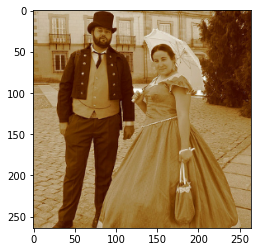

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.sum_axes = False
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.normalize_spectral_density_per_step = False
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False
config.fixed_image_num = 1 #this is a nice image
config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                    deterministic=True,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])
if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model)

In [ ]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs = agent.get_action(env.unflatten_observation(prev_state),
                                               return_stats=True)
        action = deterministic_action #hook in order to add noise if neccessary
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(prev_state)
            actions.append(action)
            rewards.append(reward)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.mean(axis=0))
            action_var_records.append(deterministic_action.var(axis=0))
            action_statmean_records.append(means)
            action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards),shaper_fn=env.unflatten_observation_v2,
                max_iterations=1000, loud=True)
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.mean()}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Training for 17 iterations with batchsize 64
Episode * 0 * Episodic Reward is ==> -19.341609417488055
action means and variances at step -10: [-0.26908224 -0.09894498] [1.10648188 0.89455586]
action means and variances at step -5: [-0.31039547 -0.06029211] [0.51289528 0.77683803]
action statmeans and variances at step -10: [-0.00218327 -0.05284859] [1. 1.]
action statmeans and variances at step -5: [-0.00310352 -0.05255474] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1 * Episodic Reward is ==> -18.81800735343583
action means and variances at step -10: [-0.09260362 -0.12228815] [0.8888305  0.72305155]
action means and variances at step -5: [-0.01790274 -0.07736789] [1.30075041 0.55011619]
action statmeans and variances at step -10: [-0.01257259 -0.01550465] [1. 1.]
action statmeans and variances at step -5: [-0.03202125  0.00294311] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2 * Episodic Reward is ==> -18.43694363880686
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 12 * Episodic Reward is ==> -17.32200930036039
action means and variances at step -10: [-0.37335971 -0.11870667] [0.98748118 0.68570499]
action means and variances at step -5: [-0.13082837 -0.22440689] [0.88964165 0.79548036]
action statmeans and variances at step -10: [-0.32058677  0.03313893] [1. 1.]
action statmeans and variances at step -5: [-0.31609792  0.03159321] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 13 * Episodic Reward is ==> -17.663213332663744
action means and variances at step -10: [-0.15690204 -0.18385842] [0.87257653 0.91608268]
action means and variances at step -5: [-0.21705228 -0.27134944] [0.9838244  0.74155743]
action statmeans and variances at step -10: [-0.3488257   0.02341767] [1. 1.]
action statmeans and variances at step -5: [-0.35048592  0.01244447] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 14 * Episodic Reward is ==> -16.807706868003663
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 24 * Episodic Reward is ==> -14.88319366905792
action means and variances at step -10: [-0.62485429 -0.14930656] [1.16389824 0.97590479]
action means and variances at step -5: [-0.69639444  0.01085443] [0.92845721 1.19437121]
action statmeans and variances at step -10: [-0.70962894  0.01483085] [1. 1.]
action statmeans and variances at step -5: [-0.7012472   0.01196437] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 25 * Episodic Reward is ==> -15.804461314638843
action means and variances at step -10: [-0.49896045 -0.25966496] [1.46515232 0.59774325]
action means and variances at step -5: [-0.82087225  0.20034877] [1.1471349  0.70803564]
action statmeans and variances at step -10: [-0.63929045  0.09409398] [1. 1.]
action statmeans and variances at step -5: [-0.6467208  0.1064027] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 26 * Episodic Reward is ==> -15.43757224810745
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 36 * Episodic Reward is ==> -15.283086674363485
action means and variances at step -10: [-0.936418    0.06399401] [1.21180746 0.74693623]
action means and variances at step -5: [-1.32602665  0.0520101 ] [1.16267128 0.52644609]
action statmeans and variances at step -10: [-0.83099896  0.17195179] [1. 1.]
action statmeans and variances at step -5: [-0.8343767   0.17264684] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 37 * Episodic Reward is ==> -15.140500497933726
action means and variances at step -10: [-1.00970688  0.13793315] [1.20796888 1.48073625]
action means and variances at step -5: [-0.88876922 -0.07496578] [1.00282568 0.89708393]
action statmeans and variances at step -10: [-0.87599564  0.17069612] [1. 1.]
action statmeans and variances at step -5: [-0.8778257   0.17188358] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 38 * Episodic Reward is ==> -14.768304087625623
action means and varian

Training for 17 iterations with batchsize 64
Episode * 48 * Episodic Reward is ==> -14.900543503180888
action means and variances at step -10: [-1.09081402  0.25351957] [0.59706548 0.81228683]
action means and variances at step -5: [-0.6498458  -0.08518018] [0.81948667 1.12312498]
action statmeans and variances at step -10: [-0.8984053   0.05308753] [1. 1.]
action statmeans and variances at step -5: [-0.90042615  0.05727527] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 49 * Episodic Reward is ==> -14.107049596076106
action means and variances at step -10: [-0.92165946 -0.15580612] [0.92377851 1.38320237]
action means and variances at step -5: [-1.12514498 -0.04494181] [0.66236315 0.85409944]
action statmeans and variances at step -10: [-1.0033568   0.05863013] [1. 1.]
action statmeans and variances at step -5: [-1.0020192  0.0625618] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 50 * Episodic Reward is ==> -13.407365317839623
action means and variance

Training for 17 iterations with batchsize 64
Episode * 60 * Episodic Reward is ==> -15.227187999835706
action means and variances at step -10: [-1.18119372  0.11061073] [1.13346971 1.02332032]
action means and variances at step -5: [-0.83901917 -0.16614536] [1.51933766 0.66402473]
action statmeans and variances at step -10: [-0.9518076  0.0823825] [1. 1.]
action statmeans and variances at step -5: [-0.9525769   0.08331665] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 61 * Episodic Reward is ==> -15.53366826039593
action means and variances at step -10: [-0.86880602 -0.1091918 ] [0.66596553 0.98092078]
action means and variances at step -5: [-1.10790832  0.11009126] [0.66620918 1.26071581]
action statmeans and variances at step -10: [-0.8544527  -0.00834331] [1. 1.]
action statmeans and variances at step -5: [-0.8612961  -0.00661559] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 62 * Episodic Reward is ==> -15.410418140571942
action means and variances

Training for 17 iterations with batchsize 64
Episode * 72 * Episodic Reward is ==> -15.227935509177918
action means and variances at step -10: [-0.91615079 -0.06884473] [1.01177927 0.8774988 ]
action means and variances at step -5: [-1.12741082  0.0561434 ] [0.45302476 0.75618686]
action statmeans and variances at step -10: [-1.0641687   0.05454121] [1. 1.]
action statmeans and variances at step -5: [-1.0602388   0.07092749] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 73 * Episodic Reward is ==> -14.316721872898288
action means and variances at step -10: [-0.83767699 -0.04578598] [0.87140103 0.78127539]
action means and variances at step -5: [-0.92338172 -0.16585381] [0.57061845 0.84607123]
action statmeans and variances at step -10: [-0.9197345  -0.08216715] [1. 1.]
action statmeans and variances at step -5: [-0.9284894  -0.08929966] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 74 * Episodic Reward is ==> -14.576055062279554
action means and varian

Training for 17 iterations with batchsize 64
Episode * 84 * Episodic Reward is ==> -15.271550663894136
action means and variances at step -10: [-0.79270584 -0.12532174] [0.90186574 1.1271808 ]
action means and variances at step -5: [-1.12560217  0.04171358] [1.88173233 0.85134298]
action statmeans and variances at step -10: [-0.9921801   0.03084052] [1. 1.]
action statmeans and variances at step -5: [-1.0050848   0.05047315] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 85 * Episodic Reward is ==> -14.75982439823499
action means and variances at step -10: [-1.26816938 -0.10860774] [1.03185827 1.2773165 ]
action means and variances at step -5: [-1.10408562 -0.12899049] [0.88601068 1.32653608]
action statmeans and variances at step -10: [-0.8779927   0.09310044] [1. 1.]
action statmeans and variances at step -5: [-0.8796653   0.09287469] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 86 * Episodic Reward is ==> -16.022411525069
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 96 * Episodic Reward is ==> -14.278932884777717
action means and variances at step -10: [-0.82618476 -0.15573136] [0.55850358 0.86650795]
action means and variances at step -5: [-0.85006936 -0.05599819] [0.87141598 0.72691259]
action statmeans and variances at step -10: [-0.994304   -0.10624254] [1. 1.]
action statmeans and variances at step -5: [-1.0036972  -0.10639909] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 97 * Episodic Reward is ==> -15.228367746053037
action means and variances at step -10: [-1.01629589 -0.01870067] [0.88167828 1.41814598]
action means and variances at step -5: [-0.82299665  0.3637671 ] [0.60832225 0.97665425]
action statmeans and variances at step -10: [-1.0120071  -0.10553299] [1. 1.]
action statmeans and variances at step -5: [-1.0120851  -0.09779647] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 98 * Episodic Reward is ==> -14.286143978190204
action means and varian

Training for 17 iterations with batchsize 64
Episode * 108 * Episodic Reward is ==> -13.273633672690952
action means and variances at step -10: [-0.75879192  0.14992239] [1.03120972 0.74800553]
action means and variances at step -5: [-0.70733937 -0.11156655] [1.05402463 0.71137528]
action statmeans and variances at step -10: [-0.89030904  0.07696907] [1. 1.]
action statmeans and variances at step -5: [-0.90263295  0.08978277] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 109 * Episodic Reward is ==> -14.365651338098488
action means and variances at step -10: [-1.11653927 -0.03282654] [1.0974429  1.15747564]
action means and variances at step -5: [-1.15160234 -0.1923217 ] [0.9265636  1.27512646]
action statmeans and variances at step -10: [-0.8382137   0.07880702] [1. 1.]
action statmeans and variances at step -5: [-0.842626    0.09383409] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 110 * Episodic Reward is ==> -14.454017702611345
action means and var

Training for 17 iterations with batchsize 64
Episode * 120 * Episodic Reward is ==> -14.794355355544733
action means and variances at step -10: [-1.20960146  0.01419662] [0.57968803 1.10100345]
action means and variances at step -5: [-1.33270437 -0.0514272 ] [0.93882948 1.11924341]
action statmeans and variances at step -10: [-1.1775753   0.11786915] [1. 1.]
action statmeans and variances at step -5: [-1.196142    0.13719267] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 121 * Episodic Reward is ==> -14.071628486500035
action means and variances at step -10: [-1.20057851 -0.14130592] [1.07275184 0.74402676]
action means and variances at step -5: [-1.05502232 -0.23657682] [1.14474532 0.94913806]
action statmeans and variances at step -10: [-1.1005868  -0.04539444] [1. 1.]
action statmeans and variances at step -5: [-1.1137764  -0.04820812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 122 * Episodic Reward is ==> -14.331885401317047
action means and var

Training for 17 iterations with batchsize 64
Episode * 132 * Episodic Reward is ==> -13.902234163601364
action means and variances at step -10: [-1.2119891   0.05366086] [0.70636281 0.63281324]
action means and variances at step -5: [-1.34069778  0.06300335] [1.14994386 1.29054812]
action statmeans and variances at step -10: [-1.1712221  -0.05858967] [1. 1.]
action statmeans and variances at step -5: [-1.1695199  -0.08144198] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 133 * Episodic Reward is ==> -13.466719995475149
action means and variances at step -10: [-1.30049377 -0.02481812] [0.8209952  0.65828399]
action means and variances at step -5: [-0.98778288 -0.22780064] [1.14415215 0.94497182]
action statmeans and variances at step -10: [-1.200001    0.08226853] [1. 1.]
action statmeans and variances at step -5: [-1.2083241   0.09888229] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 134 * Episodic Reward is ==> -14.999407946144144
action means and var

Training for 17 iterations with batchsize 64
Episode * 144 * Episodic Reward is ==> -16.255617083318008
action means and variances at step -10: [-2.60237652  0.1913195 ] [1.22180048 0.75998525]
action means and variances at step -5: [-2.1353762  -0.00497913] [1.39606907 0.58344732]
action statmeans and variances at step -10: [-2.206408    0.00804236] [1. 1.]
action statmeans and variances at step -5: [-2.208401    0.02244938] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 145 * Episodic Reward is ==> -17.278942954466856
action means and variances at step -10: [-2.0113992  -0.13538662] [0.91848392 0.90977004]
action means and variances at step -5: [-2.31358995  0.16540497] [0.78964818 0.52966049]
action statmeans and variances at step -10: [-2.160148    0.07941028] [1. 1.]
action statmeans and variances at step -5: [-2.1615977   0.09090278] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 146 * Episodic Reward is ==> -16.213944431620163
action means and var

Training for 17 iterations with batchsize 64
Episode * 156 * Episodic Reward is ==> -15.94836367398727
action means and variances at step -10: [-1.68013331  0.0247059 ] [0.88255599 1.13408931]
action means and variances at step -5: [-2.11101003  0.18235839] [1.06249727 1.1594733 ]
action statmeans and variances at step -10: [-1.936214    0.16386452] [1. 1.]
action statmeans and variances at step -5: [-1.9294549  0.1499241] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 157 * Episodic Reward is ==> -16.091024982443017
action means and variances at step -10: [-1.63958194 -0.09974915] [1.21657154 0.70420092]
action means and variances at step -5: [-1.95143469  0.01586972] [0.85530678 0.99184993]
action statmeans and variances at step -10: [-1.8615408   0.20916593] [1. 1.]
action statmeans and variances at step -5: [-1.8587184   0.17753339] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 158 * Episodic Reward is ==> -15.946376181085974
action means and varian

Training for 17 iterations with batchsize 64
Episode * 168 * Episodic Reward is ==> -14.048274299107302
action means and variances at step -10: [-1.32183068 -0.36607436] [0.95009806 1.26235296]
action means and variances at step -5: [-1.19005217  0.09689473] [0.71895883 1.21762098]
action statmeans and variances at step -10: [-1.2542756  -0.04002489] [1. 1.]
action statmeans and variances at step -5: [-1.2719125   0.06022425] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 169 * Episodic Reward is ==> -14.350762696718192
action means and variances at step -10: [-1.12140649 -0.37952179] [0.75197579 0.63236965]
action means and variances at step -5: [-1.39036573  0.01506596] [1.24073366 0.49168732]
action statmeans and variances at step -10: [-1.0999926  -0.05242605] [1. 1.]
action statmeans and variances at step -5: [-1.0911232  -0.08836361] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 170 * Episodic Reward is ==> -14.38772166229172
action means and vari

Training for 17 iterations with batchsize 64
Episode * 180 * Episodic Reward is ==> -14.015716550743065
action means and variances at step -10: [-0.76267966  0.18469566] [1.36627324 1.19500879]
action means and variances at step -5: [-0.83222403 -0.12823832] [1.03497582 1.26397066]
action statmeans and variances at step -10: [-0.91101766  0.26501486] [1. 1.]
action statmeans and variances at step -5: [-0.92424107  0.30349982] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 181 * Episodic Reward is ==> -13.345589996700902
action means and variances at step -10: [-8.09357815e-01 -3.43422099e-04] [1.03099916 0.95739242]
action means and variances at step -5: [-0.9766943   0.32068179] [1.20284046 0.70020268]
action statmeans and variances at step -10: [-0.8916684   0.24649148] [1. 1.]
action statmeans and variances at step -5: [-0.89121705  0.10438873] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 182 * Episodic Reward is ==> -13.990588977773786
action means

Training for 17 iterations with batchsize 64
Episode * 192 * Episodic Reward is ==> -14.236417170129931
action means and variances at step -10: [-1.5227815   0.07016717] [0.82034178 1.32186806]
action means and variances at step -5: [-1.38953988  0.27005466] [1.03987097 1.03849176]
action statmeans and variances at step -10: [-1.5377951  -0.07605819] [1. 1.]
action statmeans and variances at step -5: [-1.560545    0.02260782] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 193 * Episodic Reward is ==> -15.477101598580123
action means and variances at step -10: [-1.88800275 -0.06832446] [0.94283081 1.07322748]
action means and variances at step -5: [-1.69683834  0.29574438] [0.91404599 1.30548285]
action statmeans and variances at step -10: [-1.6719356  0.3913294] [1. 1.]
action statmeans and variances at step -5: [-1.6687357   0.36555228] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 194 * Episodic Reward is ==> -14.478089360104352
action means and varia

Training for 17 iterations with batchsize 64
Episode * 204 * Episodic Reward is ==> -14.655632061452263
action means and variances at step -10: [-1.75116838  0.41174424] [0.93363628 1.20201664]
action means and variances at step -5: [-1.73600815 -0.22348845] [1.05386376 0.73926956]
action statmeans and variances at step -10: [-1.5464604   0.01204446] [1. 1.]
action statmeans and variances at step -5: [-1.5514287   0.07672194] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 205 * Episodic Reward is ==> -13.684893272969347
action means and variances at step -10: [-1.07905787  0.14552493] [0.83771735 1.1044619 ]
action means and variances at step -5: [-1.88139864  0.0579133 ] [1.20793695 0.93680322]
action statmeans and variances at step -10: [-1.5557172  -0.04068379] [1. 1.]
action statmeans and variances at step -5: [-1.556389   -0.05331714] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 206 * Episodic Reward is ==> -14.006718634851687
action means and var

Training for 17 iterations with batchsize 64
Episode * 216 * Episodic Reward is ==> -13.503702186432543
action means and variances at step -10: [-1.41292852 -0.01715614] [1.07650103 1.01026149]
action means and variances at step -5: [-1.48689699 -0.16745453] [0.72855141 1.27164198]
action statmeans and variances at step -10: [-1.3782948  -0.21956542] [1. 1.]
action statmeans and variances at step -5: [-1.3787525  -0.21469477] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 217 * Episodic Reward is ==> -13.782696959815524
action means and variances at step -10: [-1.37749954  0.44324069] [1.45093383 1.25589535]
action means and variances at step -5: [-1.20731845  0.42901957] [1.21358545 0.75248096]
action statmeans and variances at step -10: [-1.4753432   0.04633078] [1. 1.]
action statmeans and variances at step -5: [-1.4612398  -0.19839269] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 218 * Episodic Reward is ==> -14.127740243488047
action means and var

Training for 17 iterations with batchsize 64
Episode * 228 * Episodic Reward is ==> -13.924538612519243
action means and variances at step -10: [-1.85554699  0.15978825] [0.85226588 0.94512744]
action means and variances at step -5: [-1.63845285  0.37039538] [1.05632123 1.18288736]
action statmeans and variances at step -10: [-1.6357975  0.4423653] [1. 1.]
action statmeans and variances at step -5: [-1.6008902   0.06131443] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 229 * Episodic Reward is ==> -13.904199271056907
action means and variances at step -10: [-1.57299937  0.08176097] [0.64441214 1.00536678]
action means and variances at step -5: [-1.55302982 -0.05387573] [0.71586067 0.87982273]
action statmeans and variances at step -10: [-1.6602018   0.24195153] [1. 1.]
action statmeans and variances at step -5: [-1.6593845   0.37658536] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 230 * Episodic Reward is ==> -14.450898632476076
action means and varia

Training for 17 iterations with batchsize 64
Episode * 240 * Episodic Reward is ==> -15.193316757663252
action means and variances at step -10: [-1.89304209  0.3822856 ] [1.12260617 1.07918773]
action means and variances at step -5: [-1.72255506  0.31259059] [0.84860694 1.30947042]
action statmeans and variances at step -10: [-1.7576649   0.40461248] [1. 1.]
action statmeans and variances at step -5: [-1.740264    0.16084749] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 241 * Episodic Reward is ==> -14.267019968978685
action means and variances at step -10: [-1.55633694 -0.08046459] [0.92544193 0.99536347]
action means and variances at step -5: [-1.61242775  0.00846702] [0.76513404 0.77509009]
action statmeans and variances at step -10: [-1.7879224  0.1361705] [1. 1.]
action statmeans and variances at step -5: [-1.788348    0.10088072] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 242 * Episodic Reward is ==> -14.013989059197968
action means and varia

Training for 17 iterations with batchsize 64
Episode * 252 * Episodic Reward is ==> -14.44622235587153
action means and variances at step -10: [-1.64624731  0.0230394 ] [1.01144955 1.54521266]
action means and variances at step -5: [-1.50835545  0.11093201] [1.24154172 0.90594619]
action statmeans and variances at step -10: [-1.879651   -0.10628313] [1. 1.]
action statmeans and variances at step -5: [-1.8691707  -0.43531996] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 253 * Episodic Reward is ==> -14.520467551334775
action means and variances at step -10: [-2.01450586  0.07722164] [1.05252119 1.44160492]
action means and variances at step -5: [-1.94881631  0.0215164 ] [0.70827284 0.97186588]
action statmeans and variances at step -10: [-1.8940632  -0.28654522] [1. 1.]
action statmeans and variances at step -5: [-1.9012432  -0.03309416] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 254 * Episodic Reward is ==> -14.361563509267937
action means and vari

Training for 17 iterations with batchsize 64
Episode * 264 * Episodic Reward is ==> -14.24366602923338
action means and variances at step -10: [-1.95698253 -0.12810088] [1.1639174  1.56913964]
action means and variances at step -5: [-1.87581211 -0.0555182 ] [1.07584705 1.05199145]
action statmeans and variances at step -10: [-2.15414    -0.30738688] [1. 1.]
action statmeans and variances at step -5: [-2.157174   -0.09778598] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 265 * Episodic Reward is ==> -15.38982272830452
action means and variances at step -10: [-2.23303726  0.38314394] [0.6620604  0.52117796]
action means and variances at step -5: [-1.97891941  0.15749703] [0.64754721 0.89890481]
action statmeans and variances at step -10: [-2.220448    0.14023986] [1. 1.]
action statmeans and variances at step -5: [-2.2176168   0.10861764] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 266 * Episodic Reward is ==> -16.1680627264875
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 276 * Episodic Reward is ==> -16.190252306927146
action means and variances at step -10: [-2.25507251 -0.04315244] [0.77919886 1.12928298]
action means and variances at step -5: [-2.68098379 -0.54042227] [1.3413491  1.38366872]
action statmeans and variances at step -10: [-2.2825093  0.1940333] [1. 1.]
action statmeans and variances at step -5: [-2.2774687  -0.44198483] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 277 * Episodic Reward is ==> -14.923948336071792
action means and variances at step -10: [-2.19293028 -0.06330439] [1.00850745 0.79230028]
action means and variances at step -5: [-2.57908887  0.12635615] [1.13233038 0.83632187]
action statmeans and variances at step -10: [-2.2886999  -0.20618284] [1. 1.]
action statmeans and variances at step -5: [-2.2865033  -0.10983393] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 278 * Episodic Reward is ==> -15.381193982230098
action means and varia

Training for 17 iterations with batchsize 64
Episode * 288 * Episodic Reward is ==> -15.193785846418425
action means and variances at step -10: [-2.1750559   0.39938274] [0.82337222 0.89698551]
action means and variances at step -5: [-2.36119719  0.24569411] [0.93807037 0.96432825]
action statmeans and variances at step -10: [-2.2571335  -0.24516101] [1. 1.]
action statmeans and variances at step -5: [-2.2780867   0.55944204] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 289 * Episodic Reward is ==> -15.659124276670067
action means and variances at step -10: [-2.16638224  0.09030386] [0.90262231 1.21332008]
action means and variances at step -5: [-2.24759193 -0.41844311] [0.77606902 0.84116667]
action statmeans and variances at step -10: [-2.285399   -0.58434224] [1. 1.]
action statmeans and variances at step -5: [-2.2859592   0.05790209] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 290 * Episodic Reward is ==> -15.298897601962405
action means and var

Training for 17 iterations with batchsize 64
Episode * 300 * Episodic Reward is ==> -14.990459980870483
action means and variances at step -10: [-1.76767176  0.04108771] [0.83143753 1.67026601]
action means and variances at step -5: [-2.27664516 -0.07750415] [0.93064373 0.87227238]
action statmeans and variances at step -10: [-2.1070054  -0.59419024] [1. 1.]
action statmeans and variances at step -5: [-2.103581    0.41537112] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 301 * Episodic Reward is ==> -14.429017455402873
action means and variances at step -10: [-1.81221771 -0.3669858 ] [1.29861476 1.75970703]
action means and variances at step -5: [-2.40694356  0.27452351] [1.34916483 1.00150529]
action statmeans and variances at step -10: [-2.0693693  0.4599983] [1. 1.]
action statmeans and variances at step -5: [-2.0638173  0.2762469] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 302 * Episodic Reward is ==> -14.796067071729425
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 312 * Episodic Reward is ==> -14.946028855372889
action means and variances at step -10: [-2.19491167  0.14179369] [0.92094706 1.14196523]
action means and variances at step -5: [-2.19455212 -0.24636613] [0.9975861  1.09459026]
action statmeans and variances at step -10: [-2.0845323  -0.19018672] [1. 1.]
action statmeans and variances at step -5: [-2.079402  -0.4453614] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 313 * Episodic Reward is ==> -14.602895274224736
action means and variances at step -10: [-2.04989873 -0.22911202] [1.21704267 0.83288396]
action means and variances at step -5: [-2.1307578e+00  8.2456341e-04] [0.94338149 1.33696846]
action statmeans and variances at step -10: [-2.1579473   0.01240918] [1. 1.]
action statmeans and variances at step -5: [-2.1683447  1.0821036] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 314 * Episodic Reward is ==> -14.556347416765092
action means and v

Training for 17 iterations with batchsize 64
Episode * 324 * Episodic Reward is ==> -13.928611977597905
action means and variances at step -10: [-2.17384049 -0.29944585] [1.2302523  1.41511292]
action means and variances at step -5: [-2.01519002 -0.48691162] [0.89967022 1.30498695]
action statmeans and variances at step -10: [-2.0616896   0.46500593] [1. 1.]
action statmeans and variances at step -5: [-2.062409    0.23222633] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 325 * Episodic Reward is ==> -14.62173872513996
action means and variances at step -10: [-1.97354231  0.25241056] [0.54994368 1.29317621]
action means and variances at step -5: [-1.54660008 -0.05999813] [0.67972458 0.86915147]
action statmeans and variances at step -10: [-1.9940346  -0.05381098] [1. 1.]
action statmeans and variances at step -5: [-2.0065236   0.29215193] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 326 * Episodic Reward is ==> -13.80755674388304
action means and varia

Training for 17 iterations with batchsize 64
Episode * 336 * Episodic Reward is ==> -13.202109392194313
action means and variances at step -10: [-1.41463493  0.02876966] [1.0764378  1.13226678]
action means and variances at step -5: [-1.35514977 -0.11250704] [0.98445086 1.51721685]
action statmeans and variances at step -10: [-1.3780811   0.88372695] [1. 1.]
action statmeans and variances at step -5: [-1.3831804 -0.9479597] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 337 * Episodic Reward is ==> -12.899520392570727
action means and variances at step -10: [-1.42686264  0.08186254] [0.46272934 1.46369717]
action means and variances at step -5: [-1.21118475 -0.06578787] [0.66526137 0.97543984]
action statmeans and variances at step -10: [-1.3250347 -1.0753084] [1. 1.]
action statmeans and variances at step -5: [-1.2936203  -0.09615751] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 338 * Episodic Reward is ==> -13.100572156094277
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 348 * Episodic Reward is ==> -13.589241668933905
action means and variances at step -10: [-1.75001579 -0.29719569] [1.3198124 1.8133113]
action means and variances at step -5: [-1.63377668  0.07264072] [0.87957855 1.30506609]
action statmeans and variances at step -10: [-1.8772888   0.10748085] [1. 1.]
action statmeans and variances at step -5: [-1.8588865  -0.84820616] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 349 * Episodic Reward is ==> -13.852602238253107
action means and variances at step -10: [-1.69552843 -0.16717618] [1.2114025  1.43212576]
action means and variances at step -5: [-2.17885528  0.3250306 ] [1.25483168 1.44088151]
action statmeans and variances at step -10: [-1.8487034   0.46865052] [1. 1.]
action statmeans and variances at step -5: [-1.8720448 -0.1644657] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 350 * Episodic Reward is ==> -13.949339627801326
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 360 * Episodic Reward is ==> -14.380112756684952
action means and variances at step -10: [-2.16551475  0.33257726] [0.77346685 1.51661167]
action means and variances at step -5: [-2.19958254 -0.09214685] [0.93982784 2.28304938]
action statmeans and variances at step -10: [-1.9948136  -0.46895093] [1. 1.]
action statmeans and variances at step -5: [-2.0707288   0.91150475] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 361 * Episodic Reward is ==> -14.473864218409032
action means and variances at step -10: [-1.82079316 -0.1889912 ] [1.04567386 1.52646423]
action means and variances at step -5: [-2.1076599   0.54049978] [1.02140837 1.38137828]
action statmeans and variances at step -10: [-2.0764372  -0.75127435] [1. 1.]
action statmeans and variances at step -5: [-2.1150863  0.6391169] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 362 * Episodic Reward is ==> -14.410796529481232
action means and varia

Training for 17 iterations with batchsize 64
Episode * 372 * Episodic Reward is ==> -13.88248227153386
action means and variances at step -10: [-2.38000433  0.16910419] [1.21274098 2.1525138 ]
action means and variances at step -5: [-2.09154346 -0.00387173] [1.1900273  1.66385962]
action statmeans and variances at step -10: [-2.2027097  0.6809361] [1. 1.]
action statmeans and variances at step -5: [-2.2087123   0.09445167] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 373 * Episodic Reward is ==> -14.523208102758215
action means and variances at step -10: [-1.98477302 -0.43321296] [0.92144081 1.34806367]
action means and variances at step -5: [-2.46921523  0.10373901] [1.21265804 1.0828631 ]
action statmeans and variances at step -10: [-2.1355848  -0.57923967] [1. 1.]
action statmeans and variances at step -5: [-2.1764936   0.19640696] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 374 * Episodic Reward is ==> -13.984042095354269
action means and varian

Training for 17 iterations with batchsize 64
Episode * 384 * Episodic Reward is ==> -14.537544738077491
action means and variances at step -10: [-1.79955748 -0.43782791] [0.68950844 1.28092028]
action means and variances at step -5: [-1.93308456 -0.27613969] [0.9231567  1.10830533]
action statmeans and variances at step -10: [-1.8562429 -1.1882917] [1. 1.]
action statmeans and variances at step -5: [-1.8842328 -0.5151667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 385 * Episodic Reward is ==> -15.294471474440218
action means and variances at step -10: [-1.95186845 -0.12307008] [0.96729524 1.82392446]
action means and variances at step -5: [-1.90730221 -0.1235984 ] [0.9412469  1.38677821]
action statmeans and variances at step -10: [-1.9127724  -0.08516039] [1. 1.]
action statmeans and variances at step -5: [-1.9209442  0.5466064] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 386 * Episodic Reward is ==> -17.356506478201588
action means and variances

Training for 17 iterations with batchsize 64
Episode * 396 * Episodic Reward is ==> -13.709505017245288
action means and variances at step -10: [-2.13997912 -0.21684414] [1.00311462 2.79251938]
action means and variances at step -5: [-1.94986185  0.02898777] [1.46169334 1.342915  ]
action statmeans and variances at step -10: [-2.1160698 -1.7709434] [1. 1.]
action statmeans and variances at step -5: [-2.0966382   0.22534427] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 397 * Episodic Reward is ==> -14.068153235911062
action means and variances at step -10: [-1.95692755  0.20860675] [0.61260273 2.95386844]
action means and variances at step -5: [-1.95241695  0.10080523] [1.5550035  1.46045221]
action statmeans and variances at step -10: [-2.0693944  0.9362063] [1. 1.]
action statmeans and variances at step -5: [-2.0399826  0.9237958] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 398 * Episodic Reward is ==> -13.55251045105337
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 408 * Episodic Reward is ==> -14.068543556065451
action means and variances at step -10: [-1.84872964  0.18362342] [1.02886425 2.015745  ]
action means and variances at step -5: [-1.75352273  0.20339402] [0.7998482  1.34810566]
action statmeans and variances at step -10: [-1.94052    0.6902469] [1. 1.]
action statmeans and variances at step -5: [-1.9777713  1.6456214] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 409 * Episodic Reward is ==> -14.010301229029217
action means and variances at step -10: [-1.96116738  0.41801192] [0.51762059 1.30693435]
action means and variances at step -5: [-2.03229545  0.22366426] [0.85463874 1.13520849]
action statmeans and variances at step -10: [-2.0267205   0.19446278] [1. 1.]
action statmeans and variances at step -5: [-2.0481896  0.6395189] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 410 * Episodic Reward is ==> -14.131651837657463
action means and variances

Training for 17 iterations with batchsize 64
Episode * 420 * Episodic Reward is ==> -13.873858460001827
action means and variances at step -10: [-1.90106358  0.52923672] [0.61898535 1.39029847]
action means and variances at step -5: [-1.77055311  0.32330484] [0.88417197 1.17472897]
action statmeans and variances at step -10: [-1.873087  1.051194] [1. 1.]
action statmeans and variances at step -5: [-1.8907218  1.1676087] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 421 * Episodic Reward is ==> -13.887307574652965
action means and variances at step -10: [-1.89286593  0.13701342] [1.01219684 1.18519873]
action means and variances at step -5: [-1.86459941 -0.14100312] [0.84854004 1.3022793 ]
action statmeans and variances at step -10: [-1.847796  -0.8188727] [1. 1.]
action statmeans and variances at step -5: [-1.8846242  -0.16921619] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 422 * Episodic Reward is ==> -13.951256679229893
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 432 * Episodic Reward is ==> -14.022721018659716
action means and variances at step -10: [-2.02323409  0.36391351] [1.21738341 1.5651443 ]
action means and variances at step -5: [-1.99771747  0.0093679 ] [0.58964446 1.49309148]
action statmeans and variances at step -10: [-2.0771985  0.7452726] [1. 1.]
action statmeans and variances at step -5: [-2.0597575   0.94060075] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 433 * Episodic Reward is ==> -13.776964518614687
action means and variances at step -10: [-2.09749361 -0.1659641 ] [0.91738138 1.67792976]
action means and variances at step -5: [-1.6271258   0.61465668] [1.09325978 1.67833013]
action statmeans and variances at step -10: [-2.010647   1.2641472] [1. 1.]
action statmeans and variances at step -5: [-1.9813972  0.3575417] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 434 * Episodic Reward is ==> -13.67612227822749
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 444 * Episodic Reward is ==> -15.78878856018614
action means and variances at step -10: [-2.46146436 -0.19127687] [0.86238924 1.72641025]
action means and variances at step -5: [-2.53595375 -0.41748951] [1.22773127 1.58387312]
action statmeans and variances at step -10: [-2.2749062  -0.01385126] [1. 1.]
action statmeans and variances at step -5: [-2.3005974  0.8404678] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 445 * Episodic Reward is ==> -14.892997862819744
action means and variances at step -10: [-2.13612932 -0.33493391] [0.83251038 1.19684767]
action means and variances at step -5: [-2.33914537 -0.40334499] [0.82285494 1.3373294 ]
action statmeans and variances at step -10: [-2.2838264   0.40892646] [1. 1.]
action statmeans and variances at step -5: [-2.2910452  -0.62265605] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 446 * Episodic Reward is ==> -14.647828981757748
action means and varian

Training for 17 iterations with batchsize 64
Episode * 456 * Episodic Reward is ==> -14.021325375663233
action means and variances at step -10: [-2.38847593  0.16767951] [0.87217407 2.40503661]
action means and variances at step -5: [-2.0942232  -0.05132136] [0.78197164 1.90789427]
action statmeans and variances at step -10: [-2.08327   -1.5509989] [1. 1.]
action statmeans and variances at step -5: [-2.1905973  1.7099901] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 457 * Episodic Reward is ==> -14.005769205651582
action means and variances at step -10: [-1.99548929  0.16539034] [0.89805998 1.67965321]
action means and variances at step -5: [-2.08259205 -0.25767353] [1.01287978 1.79906093]
action statmeans and variances at step -10: [-2.1164784  0.2049537] [1. 1.]
action statmeans and variances at step -5: [-2.0857906 -0.9760385] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 458 * Episodic Reward is ==> -14.132083065475047
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 468 * Episodic Reward is ==> -13.77476844159778
action means and variances at step -10: [-1.99124166 -0.16659943] [0.71467892 3.00438552]
action means and variances at step -5: [-2.00354583 -0.37562391] [0.82706059 1.58238393]
action statmeans and variances at step -10: [-1.9605374  -0.89999664] [1. 1.]
action statmeans and variances at step -5: [-2.0960946  1.0758401] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 469 * Episodic Reward is ==> -13.850166004262846
action means and variances at step -10: [-2.06100014 -0.46063532] [0.7201083  1.99618576]
action means and variances at step -5: [-1.98074254 -0.01661197] [0.97237127 2.09914868]
action statmeans and variances at step -10: [-1.9934914 -1.4445336] [1. 1.]
action statmeans and variances at step -5: [-2.0908031   0.96543324] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 470 * Episodic Reward is ==> -13.885769200083033
action means and variance

Training for 17 iterations with batchsize 64
Episode * 480 * Episodic Reward is ==> -16.81935335517646
action means and variances at step -10: [-2.21102592  0.59022252] [1.41748989 1.43048419]
action means and variances at step -5: [-2.40083535  0.63478882] [1.65345989 1.8629153 ]
action statmeans and variances at step -10: [-2.1541114  1.1632739] [1. 1.]
action statmeans and variances at step -5: [-2.1576443   0.44220302] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 481 * Episodic Reward is ==> -18.439341902846515
action means and variances at step -10: [-2.06942722  0.93884941] [0.60756464 0.56272908]
action means and variances at step -5: [-2.16041794  1.16564401] [0.83375327 1.04396102]
action statmeans and variances at step -10: [-2.2040174  1.6889548] [1. 1.]
action statmeans and variances at step -5: [-2.1949105  1.2104862] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 482 * Episodic Reward is ==> -16.03818805763229
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 492 * Episodic Reward is ==> -14.570855358514105
action means and variances at step -10: [-2.1308171   0.17050915] [1.46241749 2.68160269]
action means and variances at step -5: [-2.19200872 -0.19492632] [0.91240943 2.21543663]
action statmeans and variances at step -10: [-2.2528315 -1.7053242] [1. 1.]
action statmeans and variances at step -5: [-2.3195968 -1.1114249] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 493 * Episodic Reward is ==> -14.890777991062453
action means and variances at step -10: [-2.44186592  0.42532171] [0.57695499 2.77959881]
action means and variances at step -5: [-2.30950881 -0.62349301] [0.80412965 1.81962876]
action statmeans and variances at step -10: [-2.3422232   0.67949265] [1. 1.]
action statmeans and variances at step -5: [-2.3587139   0.70171785] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 494 * Episodic Reward is ==> -14.98882851691265
action means and variance

Training for 17 iterations with batchsize 64
Episode * 504 * Episodic Reward is ==> -14.468957978627344
action means and variances at step -10: [-2.21442053 -0.19113081] [1.31421004 1.2822043 ]
action means and variances at step -5: [-2.44564196 -0.57606046] [1.02266864 1.33275028]
action statmeans and variances at step -10: [-2.1655002 -1.6904414] [1. 1.]
action statmeans and variances at step -5: [-2.2337334  -0.10333683] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 505 * Episodic Reward is ==> -14.81148590040469
action means and variances at step -10: [-2.07394813 -0.26157687] [1.14463852 1.31245231]
action means and variances at step -5: [-2.06190942 -0.35019497] [0.62708174 1.21132269]
action statmeans and variances at step -10: [-2.2482264   0.32228982] [1. 1.]
action statmeans and variances at step -5: [-2.250442  -0.4263847] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 506 * Episodic Reward is ==> -13.93580177475953
action means and variances

Training for 17 iterations with batchsize 64
Episode * 516 * Episodic Reward is ==> -14.039213871872523
action means and variances at step -10: [-1.92995099 -0.10280006] [1.17831342 1.84913918]
action means and variances at step -5: [-2.11408472 -0.66961265] [0.89638869 2.42299493]
action statmeans and variances at step -10: [-1.8809935 -1.3207072] [1. 1.]
action statmeans and variances at step -5: [-1.8969302 -1.376459 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 517 * Episodic Reward is ==> -14.053157650353214
action means and variances at step -10: [-2.09665839 -0.34458013] [1.02528046 2.42744804]
action means and variances at step -5: [-1.67878858 -0.53378381] [1.3793937  2.17557871]
action statmeans and variances at step -10: [-1.9719894  0.3995542] [1. 1.]
action statmeans and variances at step -5: [-1.9697596  -0.77506244] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 518 * Episodic Reward is ==> -13.947606723983021
action means and variances

Training for 17 iterations with batchsize 64
Episode * 528 * Episodic Reward is ==> -13.651108704369577
action means and variances at step -10: [-1.86838903 -0.25674763] [1.40330657 2.41587259]
action means and variances at step -5: [-1.63929752 -0.6781328 ] [0.67685512 2.50763794]
action statmeans and variances at step -10: [-1.7535067 -1.4913853] [1. 1.]
action statmeans and variances at step -5: [-1.8382237 -1.9687847] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 529 * Episodic Reward is ==> -13.499346242168826
action means and variances at step -10: [-1.66474074 -0.35972161] [1.12451482 2.54995978]
action means and variances at step -5: [-1.58698856 -0.29716852] [0.88257664 2.49902982]
action statmeans and variances at step -10: [-1.8699307  2.2585135] [1. 1.]
action statmeans and variances at step -5: [-1.779598    0.03826046] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 530 * Episodic Reward is ==> -14.208049127511721
action means and variances

Training for 17 iterations with batchsize 64
Episode * 540 * Episodic Reward is ==> -13.788423198150246
action means and variances at step -10: [-1.9175658  -0.29479035] [0.64569464 3.3252692 ]
action means and variances at step -5: [-2.16053882 -0.29383851] [1.0188199  4.27756068]
action statmeans and variances at step -10: [-1.795306  -1.4429101] [1. 1.]
action statmeans and variances at step -5: [-1.8460704 -1.564126 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 541 * Episodic Reward is ==> -13.808625654035987
action means and variances at step -10: [-1.80556315 -0.21207883] [1.01731086 3.59697037]
action means and variances at step -5: [-2.02751804 -0.70373907] [1.28040352 2.49600249]
action statmeans and variances at step -10: [-1.9023446  0.2696715] [1. 1.]
action statmeans and variances at step -5: [-1.9036448  -0.29098907] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 542 * Episodic Reward is ==> -13.765741041735176
action means and variances

Training for 17 iterations with batchsize 64
Episode * 552 * Episodic Reward is ==> -15.370211307520353
action means and variances at step -10: [-2.01563412 -0.79226202] [0.88988458 1.67573933]
action means and variances at step -5: [-2.00342753 -0.26751583] [0.91124765 2.29367956]
action statmeans and variances at step -10: [-1.9448315 -1.481113 ] [1. 1.]
action statmeans and variances at step -5: [-1.9938936 -0.4920239] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 553 * Episodic Reward is ==> -15.512594078453088
action means and variances at step -10: [-2.03146876 -0.42901482] [0.63480692 1.25982468]
action means and variances at step -5: [-1.66836904 -0.42857633] [0.72263399 1.68832744]
action statmeans and variances at step -10: [-1.8673671 -1.2368422] [1. 1.]
action statmeans and variances at step -5: [-1.9160049 -1.8724542] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 554 * Episodic Reward is ==> -14.635250603214839
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 564 * Episodic Reward is ==> -13.890588369470901
action means and variances at step -10: [-1.72822183  0.10027495] [0.34377091 2.53714612]
action means and variances at step -5: [-1.88359799 -0.37171815] [0.8943748  4.33825074]
action statmeans and variances at step -10: [-1.7741722   0.78449976] [1. 1.]
action statmeans and variances at step -5: [-1.8136929  0.6839762] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 565 * Episodic Reward is ==> -13.889874869033955
action means and variances at step -10: [-1.54723836  0.3623262 ] [1.23981859 3.5096956 ]
action means and variances at step -5: [-1.58695852 -0.25281858] [0.7259406  3.56219301]
action statmeans and variances at step -10: [-1.8371329   0.87823516] [1. 1.]
action statmeans and variances at step -5: [-1.7783294 -1.0051281] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 566 * Episodic Reward is ==> -14.259513540411618
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 576 * Episodic Reward is ==> -13.650832398881857
action means and variances at step -10: [-1.79831106 -0.07244264] [1.33340171 3.37619407]
action means and variances at step -5: [-2.0959983  -0.24016685] [1.10673375 2.63375221]
action statmeans and variances at step -10: [-2.0122557  1.7952964] [1. 1.]
action statmeans and variances at step -5: [-1.9182462  -0.28445053] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 577 * Episodic Reward is ==> -13.845602182169838
action means and variances at step -10: [-1.87988338 -0.07129763] [0.93091852 3.33254184]
action means and variances at step -5: [-2.04465086 -0.42334921] [0.62652627 2.60090078]
action statmeans and variances at step -10: [-1.8023454 -1.9253736] [1. 1.]
action statmeans and variances at step -5: [-2.0026608  1.597077 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 578 * Episodic Reward is ==> -13.286175555829054
action means and variances

Training for 17 iterations with batchsize 64
Episode * 588 * Episodic Reward is ==> -14.047082959441171
action means and variances at step -10: [-2.37840073 -0.00994742] [0.71955682 3.44653032]
action means and variances at step -5: [-2.07854881  0.00791506] [1.03511562 2.16278723]
action statmeans and variances at step -10: [-1.8989035 -2.1734543] [1. 1.]
action statmeans and variances at step -5: [-2.0080855  0.3659194] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 589 * Episodic Reward is ==> -15.726978321048302
action means and variances at step -10: [-2.01169241 -0.12581887] [0.97043744 3.0396618 ]
action means and variances at step -5: [-2.3024855   0.19317439] [0.76148959 2.05666077]
action statmeans and variances at step -10: [-2.0379806   0.17036375] [1. 1.]
action statmeans and variances at step -5: [-2.2249765  2.4583907] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 590 * Episodic Reward is ==> -17.80720473353248
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 600 * Episodic Reward is ==> -15.770122333196312
action means and variances at step -10: [-1.80666597 -0.18388629] [0.84565012 2.69317104]
action means and variances at step -5: [-1.80923643  0.14878599] [0.78902168 3.62057954]
action statmeans and variances at step -10: [-1.7420006 -2.1131022] [1. 1.]
action statmeans and variances at step -5: [-1.8764112 -0.76237  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 601 * Episodic Reward is ==> -16.108040037905127
action means and variances at step -10: [-1.8985948   0.69348274] [0.66765964 2.2228603 ]
action means and variances at step -5: [-2.06175747  0.38896365] [1.17758766 1.98942298]
action statmeans and variances at step -10: [-1.8770869 -1.518234 ] [1. 1.]
action statmeans and variances at step -5: [-2.044205   0.9702507] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 602 * Episodic Reward is ==> -18.138589828859338
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 612 * Episodic Reward is ==> -17.35695437647852
action means and variances at step -10: [-1.59334147 -0.15511316] [1.63897054 2.81128597]
action means and variances at step -5: [-1.8806763  0.1836906] [0.92896797 1.78176449]
action statmeans and variances at step -10: [-1.8398724  -0.82738876] [1. 1.]
action statmeans and variances at step -5: [-1.8058773 -1.6853156] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 613 * Episodic Reward is ==> -15.896558559954364
action means and variances at step -10: [-1.88420167  0.3237486 ] [0.58993521 4.25102436]
action means and variances at step -5: [-1.93974605 -0.24072677] [1.02948897 4.6008381 ]
action statmeans and variances at step -10: [-1.8860204  1.4825711] [1. 1.]
action statmeans and variances at step -5: [-1.7144945 -2.415241 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 614 * Episodic Reward is ==> -15.736480178635471
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 624 * Episodic Reward is ==> -15.706409458878671
action means and variances at step -10: [-1.35790854  0.63481769] [0.90992879 3.09520093]
action means and variances at step -5: [-1.39466279 -0.12164087] [1.33179115 4.36816098]
action statmeans and variances at step -10: [-1.4108863 -1.0174593] [1. 1.]
action statmeans and variances at step -5: [-1.4871153 -0.305595 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 625 * Episodic Reward is ==> -14.813492561432014
action means and variances at step -10: [-1.28629741  0.2533677 ] [1.28213773 4.92573312]
action means and variances at step -5: [-1.82505427 -0.67525723] [0.90746899 4.3753029 ]
action statmeans and variances at step -10: [-1.5744555  1.4648855] [1. 1.]
action statmeans and variances at step -5: [-1.5991026  1.3243257] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 626 * Episodic Reward is ==> -14.682902344115268
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 636 * Episodic Reward is ==> -13.41660011636669
action means and variances at step -10: [-1.36492695 -0.00570931] [0.85213009 2.10308537]
action means and variances at step -5: [-1.4705179  -0.06309696] [1.07294422 1.95035297]
action statmeans and variances at step -10: [-1.3988355  1.3482436] [1. 1.]
action statmeans and variances at step -5: [-1.2747567  -0.25059053] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 637 * Episodic Reward is ==> -15.498664299288507
action means and variances at step -10: [-1.47686543  0.32357746] [1.53113027 1.08080222]
action means and variances at step -5: [-1.48192271 -0.17712618] [1.45675028 0.7688207 ]
action statmeans and variances at step -10: [-1.4493004  0.6854285] [1. 1.]
action statmeans and variances at step -5: [-1.4325165   0.36448842] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 638 * Episodic Reward is ==> -20.41960297192429
action means and variances

Training for 17 iterations with batchsize 64
Episode * 648 * Episodic Reward is ==> -12.732324468683354
action means and variances at step -10: [-1.47324238  0.37492737] [0.91228106 3.76588748]
action means and variances at step -5: [-1.2712555 -0.1634686] [1.348278   3.98001931]
action statmeans and variances at step -10: [-1.3258808  1.8494885] [1. 1.]
action statmeans and variances at step -5: [-1.1085675 -0.9677616] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 649 * Episodic Reward is ==> -12.629826017397676
action means and variances at step -10: [-1.32903612 -0.24170813] [1.09998673 2.88291428]
action means and variances at step -5: [-1.24061087 -0.17782594] [1.0178411  3.13997621]
action statmeans and variances at step -10: [-1.1384568  0.6811726] [1. 1.]
action statmeans and variances at step -5: [-1.3642769  2.1086445] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 650 * Episodic Reward is ==> -12.939514466616043
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 660 * Episodic Reward is ==> -13.7359908621595
action means and variances at step -10: [-1.20678345 -0.31943607] [1.03479991 1.57550793]
action means and variances at step -5: [-1.51709435 -0.43660551] [1.17215373 1.41732909]
action statmeans and variances at step -10: [-1.3204732  0.3467952] [1. 1.]
action statmeans and variances at step -5: [-1.3114984  -0.20602232] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 661 * Episodic Reward is ==> -12.94902535681313
action means and variances at step -10: [-1.02247376 -0.29589768] [0.54358727 1.15987052]
action means and variances at step -5: [-1.46521536 -0.05559788] [1.05302626 1.58205076]
action statmeans and variances at step -10: [-1.3225932   0.17728277] [1. 1.]
action statmeans and variances at step -5: [-1.4251384  1.1739423] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 662 * Episodic Reward is ==> -13.429986421977883
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 672 * Episodic Reward is ==> -13.414791705650305
action means and variances at step -10: [-1.64449389  0.25108477] [1.15602464 2.84750306]
action means and variances at step -5: [-1.83798665  0.08161203] [1.21904255 2.4894003 ]
action statmeans and variances at step -10: [-1.9028375  2.054664 ] [1. 1.]
action statmeans and variances at step -5: [-1.6810982  -0.21900931] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 673 * Episodic Reward is ==> -13.331642210245555
action means and variances at step -10: [-1.81839963 -0.10949444] [1.08455377 2.28215214]
action means and variances at step -5: [-1.720366   -0.31381897] [0.97631096 3.13647914]
action statmeans and variances at step -10: [-1.8330148  1.5184089] [1. 1.]
action statmeans and variances at step -5: [-1.8276296  1.4377115] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 674 * Episodic Reward is ==> -13.524736070450672
action means and variances

Training for 17 iterations with batchsize 64
Episode * 684 * Episodic Reward is ==> -13.77248601590276
action means and variances at step -10: [-1.46066707 -0.12074074] [1.16494598 5.32715442]
action means and variances at step -5: [-1.37655196 -0.1993964 ] [0.71569932 3.33052069]
action statmeans and variances at step -10: [-1.9723173  2.568697 ] [1. 1.]
action statmeans and variances at step -5: [-1.4373384 -1.7386011] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 685 * Episodic Reward is ==> -13.803355288303047
action means and variances at step -10: [-1.54168432  0.21407876] [1.0486873  5.14112242]
action means and variances at step -5: [-1.75914568 -0.22334777] [1.35207839 2.81517198]
action statmeans and variances at step -10: [-1.786978  1.545449] [1. 1.]
action statmeans and variances at step -5: [-1.4446453 -1.6610365] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 686 * Episodic Reward is ==> -14.363771456080556
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 696 * Episodic Reward is ==> -12.802499925220342
action means and variances at step -10: [-1.09371813  0.20048998] [1.34646411 5.2606767 ]
action means and variances at step -5: [-1.05015093  0.30410377] [0.85868991 6.32743399]
action statmeans and variances at step -10: [-0.73939514 -1.8770826 ] [1. 1.]
action statmeans and variances at step -5: [-1.5428212  2.4119387] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 697 * Episodic Reward is ==> -12.529318838642205
action means and variances at step -10: [-1.18333734 -0.09508754] [0.78197672 5.39311495]
action means and variances at step -5: [-1.0771534   0.04993297] [0.93658403 3.57176584]
action statmeans and variances at step -10: [-1.2475923  1.6660533] [1. 1.]
action statmeans and variances at step -5: [-1.605715   2.5614076] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 698 * Episodic Reward is ==> -12.347600267483493
action means and variances

Training for 17 iterations with batchsize 64
Episode * 708 * Episodic Reward is ==> -12.337583570879328
action means and variances at step -10: [-0.66004848 -0.3160049 ] [0.8825716  3.26626071]
action means and variances at step -5: [-0.76730747  0.33236054] [0.94075337 1.41272274]
action statmeans and variances at step -10: [-1.2202823  1.4719596] [1. 1.]
action statmeans and variances at step -5: [-0.9838702  -0.22651172] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 709 * Episodic Reward is ==> -12.306107524905569
action means and variances at step -10: [-0.42325408 -0.55566604] [0.98617031 2.32661049]
action means and variances at step -5: [-0.93896819 -0.17341409] [1.07256239 1.42954735]
action statmeans and variances at step -10: [-0.9455078  -0.12383465] [1. 1.]
action statmeans and variances at step -5: [-1.1072004  0.8519957] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 710 * Episodic Reward is ==> -12.260820433228927
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 720 * Episodic Reward is ==> -11.911141439246723
action means and variances at step -10: [-0.91083658 -0.30203957] [0.69836581 2.60843093]
action means and variances at step -5: [-0.86878088 -0.24307868] [0.91111012 2.00907961]
action statmeans and variances at step -10: [-0.7733375 -1.5272322] [1. 1.]
action statmeans and variances at step -5: [-0.9885876  -0.54621124] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 721 * Episodic Reward is ==> -11.785888624503134
action means and variances at step -10: [-0.9431375  -0.06443958] [1.22557695 1.7359357 ]
action means and variances at step -5: [-0.93082278 -0.38822256] [1.21787921 1.14407226]
action statmeans and variances at step -10: [-1.0440304  -0.27200565] [1. 1.]
action statmeans and variances at step -5: [-1.1373307  0.3529361] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 722 * Episodic Reward is ==> -11.605450741487413
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 732 * Episodic Reward is ==> -11.65131652792022
action means and variances at step -10: [-1.16144797 -0.12093213] [1.22808671 1.85541337]
action means and variances at step -5: [-0.81509001  0.40221601] [0.97999805 2.43916766]
action statmeans and variances at step -10: [-1.0215392   0.68077075] [1. 1.]
action statmeans and variances at step -5: [-1.1095406  1.1380032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 733 * Episodic Reward is ==> -11.656039386498403
action means and variances at step -10: [-0.73252287 -0.50996794] [0.8653415  2.56631143]
action means and variances at step -5: [-0.95132718  0.37874216] [0.45367608 1.76341963]
action statmeans and variances at step -10: [-1.1021686  0.5607642] [1. 1.]
action statmeans and variances at step -5: [-1.1031802  0.8561243] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 734 * Episodic Reward is ==> -11.659449474020246
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 744 * Episodic Reward is ==> -11.401312998144853
action means and variances at step -10: [-0.70127506  0.01269889] [0.78772103 1.75365014]
action means and variances at step -5: [-0.71657111 -0.45715161] [1.07924513 2.38968276]
action statmeans and variances at step -10: [-0.34249783 -1.1177104 ] [1. 1.]
action statmeans and variances at step -5: [-0.3467957 -1.3742635] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 745 * Episodic Reward is ==> -11.890181670804953
action means and variances at step -10: [-0.86520311  0.16594156] [0.92829305 1.89078342]
action means and variances at step -5: [-0.6861658   0.08223049] [0.75248565 1.73888611]
action statmeans and variances at step -10: [-0.8149588  1.128688 ] [1. 1.]
action statmeans and variances at step -5: [-0.7441596  0.9376868] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 746 * Episodic Reward is ==> -11.59723654953142
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 756 * Episodic Reward is ==> -11.635270295910875
action means and variances at step -10: [-0.808712   -0.05575923] [0.90009443 2.16289889]
action means and variances at step -5: [-1.06304119  0.07760845] [1.24702141 1.48612038]
action statmeans and variances at step -10: [-0.57525015 -1.2725403 ] [1. 1.]
action statmeans and variances at step -5: [-1.1962793  1.8576332] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 757 * Episodic Reward is ==> -11.820935221481967
action means and variances at step -10: [-0.85143017  0.33698033] [1.13626928 1.76008872]
action means and variances at step -5: [-1.00360632  0.30054328] [0.93570705 1.53475831]
action statmeans and variances at step -10: [-0.60838103 -0.5397353 ] [1. 1.]
action statmeans and variances at step -5: [-0.69835234 -0.2473971 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 758 * Episodic Reward is ==> -11.449643407900428
action means and varia

Training for 17 iterations with batchsize 64
Episode * 768 * Episodic Reward is ==> -11.229229732472218
action means and variances at step -10: [-0.47480352 -0.11696871] [0.77806031 2.36180343]
action means and variances at step -5: [-0.46906357  0.13218886] [0.64360355 2.43858332]
action statmeans and variances at step -10: [-0.44951132 -0.57077783] [1. 1.]
action statmeans and variances at step -5: [-0.4979631  -0.47422457] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 769 * Episodic Reward is ==> -11.176534530975736
action means and variances at step -10: [-0.25529099 -0.14297207] [0.67601744 1.82770141]
action means and variances at step -5: [-0.29527509 -0.16575116] [0.67693023 1.56247763]
action statmeans and variances at step -10: [-0.93598527  1.7217021 ] [1. 1.]
action statmeans and variances at step -5: [-0.4534024 -1.367491 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 770 * Episodic Reward is ==> -11.552613965401598
action means and varia

Training for 17 iterations with batchsize 64
Episode * 780 * Episodic Reward is ==> -11.486777283305539
action means and variances at step -10: [-0.79175313 -0.17406712] [0.98073145 2.14747436]
action means and variances at step -5: [-0.51656544 -0.84011968] [1.15408498 1.45634865]
action statmeans and variances at step -10: [-0.4310338   0.58735365] [1. 1.]
action statmeans and variances at step -5: [-0.24371615 -0.82655275] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 781 * Episodic Reward is ==> -11.358923878541981
action means and variances at step -10: [-0.51833241  0.03260341] [1.2134797  3.04819598]
action means and variances at step -5: [-0.63589482 -0.10347251] [0.57577296 2.11258127]
action statmeans and variances at step -10: [-0.5622462 -2.211248 ] [1. 1.]
action statmeans and variances at step -5: [-0.7379427  1.2803719] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 782 * Episodic Reward is ==> -11.772006348961455
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 792 * Episodic Reward is ==> -11.075539518488583
action means and variances at step -10: [-0.44333466 -0.31159203] [0.51374501 3.21563967]
action means and variances at step -5: [-0.81551494 -0.54401467] [1.4212642  1.68732407]
action statmeans and variances at step -10: [-0.43694288 -0.45933464] [1. 1.]
action statmeans and variances at step -5: [-0.3847751 -1.2900265] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 793 * Episodic Reward is ==> -11.566961291175193
action means and variances at step -10: [-0.7281852   0.22561629] [1.95938906 2.13839167]
action means and variances at step -5: [-0.73112241  0.0734111 ] [1.13325315 3.09081298]
action statmeans and variances at step -10: [-0.83369756  0.4074971 ] [1. 1.]
action statmeans and variances at step -5: [-1.0665402  1.682663 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 794 * Episodic Reward is ==> -11.487853750410597
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 804 * Episodic Reward is ==> -11.485958094841621
action means and variances at step -10: [-0.71462954 -0.11104401] [1.15191161 1.64040156]
action means and variances at step -5: [-0.53145309 -0.01760522] [1.1019983  2.36574462]
action statmeans and variances at step -10: [-0.3531831 -0.9568274] [1. 1.]
action statmeans and variances at step -5: [-0.50535685  0.18193948] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 805 * Episodic Reward is ==> -11.202845634695631
action means and variances at step -10: [-0.50213359 -0.18585746] [0.59129714 2.15592358]
action means and variances at step -5: [-0.74784448 -0.20917576] [0.7036686  2.00797811]
action statmeans and variances at step -10: [-0.26397312 -1.057287  ] [1. 1.]
action statmeans and variances at step -5: [-0.56353176 -0.42038396] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 806 * Episodic Reward is ==> -11.304910809818196
action means and varia

Training for 17 iterations with batchsize 64
Episode * 816 * Episodic Reward is ==> -11.303656943148123
action means and variances at step -10: [-0.39398364 -0.00884434] [1.09273595 3.41564015]
action means and variances at step -5: [-0.12760099 -0.01304938] [0.89680648 2.06023695]
action statmeans and variances at step -10: [-0.6401914  1.0266523] [1. 1.]
action statmeans and variances at step -5: [-0.93219733  1.7481761 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 817 * Episodic Reward is ==> -11.368348793104571
action means and variances at step -10: [-0.22887313 -0.47875416] [1.56536588 2.01759301]
action means and variances at step -5: [-0.20141797  0.09836718] [0.74927347 2.34543822]
action statmeans and variances at step -10: [-0.7527879  1.5684433] [1. 1.]
action statmeans and variances at step -5: [-0.01105772 -0.83465105] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 818 * Episodic Reward is ==> -11.588907169847673
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 828 * Episodic Reward is ==> -11.561700797558805
action means and variances at step -10: [-0.50885052 -0.4043408 ] [1.2956007  3.55550446]
action means and variances at step -5: [-0.39342837 -0.25500859] [0.93620554 2.99918121]
action statmeans and variances at step -10: [-0.11466396 -0.711707  ] [1. 1.]
action statmeans and variances at step -5: [-0.8227085  1.061302 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 829 * Episodic Reward is ==> -11.803385700292067
action means and variances at step -10: [-0.61045066  0.31033641] [1.23519266 1.86949402]
action means and variances at step -5: [-0.72221682  0.26375303] [1.91456529 2.37169078]
action statmeans and variances at step -10: [-1.491341   2.2401655] [1. 1.]
action statmeans and variances at step -5: [-0.82585233  1.0607977 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 830 * Episodic Reward is ==> -11.24139233454756
action means and variance

Training for 17 iterations with batchsize 64
Episode * 840 * Episodic Reward is ==> -11.354179449597265
action means and variances at step -10: [-0.69044411  0.15824215] [1.22424518 2.21657212]
action means and variances at step -5: [-0.8619136  -0.09270486] [0.98849188 2.42429303]
action statmeans and variances at step -10: [-0.25481388 -0.71577996] [1. 1.]
action statmeans and variances at step -5: [-0.44046438 -0.17289716] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 841 * Episodic Reward is ==> -11.265124105261426
action means and variances at step -10: [-0.23298146 -0.12322966] [1.36106524 2.53788241]
action means and variances at step -5: [-0.37782204  0.14222292] [0.96848866 2.16522715]
action statmeans and variances at step -10: [-0.97313607  1.4990017 ] [1. 1.]
action statmeans and variances at step -5: [-0.6151345  0.5803034] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 842 * Episodic Reward is ==> -11.031482976691137
action means and varia

Training for 17 iterations with batchsize 64
Episode * 852 * Episodic Reward is ==> -11.33916860830293
action means and variances at step -10: [-0.14062301 -0.23153659] [0.96849478 2.0643217 ]
action means and variances at step -5: [-0.31922074 -0.08906435] [1.78629732 1.74028007]
action statmeans and variances at step -10: [-0.01980041 -0.91590834] [1. 1.]
action statmeans and variances at step -5: [-0.01835808 -0.45523578] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 853 * Episodic Reward is ==> -11.295549489801733
action means and variances at step -10: [-0.59176713 -0.05418027] [1.19909984 1.72706414]
action means and variances at step -5: [-0.34370579  0.00056609] [1.40119464 1.96401685]
action statmeans and variances at step -10: [-0.8879597  1.475331 ] [1. 1.]
action statmeans and variances at step -5: [-0.23154497 -0.53848535] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 854 * Episodic Reward is ==> -11.19284991795527
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 864 * Episodic Reward is ==> -11.459439238823494
action means and variances at step -10: [-0.63394977 -0.24851871] [1.31207027 1.55113422]
action means and variances at step -5: [-0.39821956 -0.24816154] [1.2896335 2.655521 ]
action statmeans and variances at step -10: [-0.3618057 -1.0327232] [1. 1.]
action statmeans and variances at step -5: [-0.38783804 -1.3417993 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 865 * Episodic Reward is ==> -11.266046064070549
action means and variances at step -10: [-1.13575978 -0.01725361] [1.66040728 2.14201847]
action means and variances at step -5: [-0.90057936 -0.18239831] [0.92871249 1.80137185]
action statmeans and variances at step -10: [-0.8075074  -0.39308172] [1. 1.]
action statmeans and variances at step -5: [-0.6700498  -0.74022025] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 866 * Episodic Reward is ==> -11.681294192760415
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 876 * Episodic Reward is ==> -11.367345412838194
action means and variances at step -10: [-0.71717593  0.01535787] [1.35142335 3.24300887]
action means and variances at step -5: [-0.55875479 -0.1528011 ] [1.15818813 2.0344216 ]
action statmeans and variances at step -10: [-0.48716468 -1.3968141 ] [1. 1.]
action statmeans and variances at step -5: [-0.5844295 -1.8733077] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 877 * Episodic Reward is ==> -11.037851912130117
action means and variances at step -10: [-0.97361769  0.29322163] [1.53976907 3.16045819]
action means and variances at step -5: [-0.76818868 -0.18491416] [0.5361533  2.53124766]
action statmeans and variances at step -10: [-0.29627648 -1.0988235 ] [1. 1.]
action statmeans and variances at step -5: [-0.71021855  0.01077679] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 878 * Episodic Reward is ==> -11.148564156146048
action means and varia

Training for 17 iterations with batchsize 64
Episode * 888 * Episodic Reward is ==> -11.226212768903405
action means and variances at step -10: [-0.58732406 -0.0607985 ] [1.17790937 1.83795885]
action means and variances at step -5: [-0.72340868 -0.36630603] [0.86498768 2.16977125]
action statmeans and variances at step -10: [-0.41512102 -1.6489052 ] [1. 1.]
action statmeans and variances at step -5: [-0.41656083 -1.3809339 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 889 * Episodic Reward is ==> -11.208370200613905
action means and variances at step -10: [-0.64021025 -0.00351706] [1.33159113 1.26564084]
action means and variances at step -5: [-0.84400553  0.00670457] [1.00615969 1.26114948]
action statmeans and variances at step -10: [-0.38447994 -0.51653814] [1. 1.]
action statmeans and variances at step -5: [-0.88540983  0.56877327] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 890 * Episodic Reward is ==> -11.091855563487847
action means and var

Training for 17 iterations with batchsize 64
Episode * 900 * Episodic Reward is ==> -11.226663072183388
action means and variances at step -10: [-0.4893253   0.32548384] [1.05243    1.46282351]
action means and variances at step -5: [-0.47409184  0.130861  ] [1.0439865  1.26205229]
action statmeans and variances at step -10: [-0.30705264 -0.7848023 ] [1. 1.]
action statmeans and variances at step -5: [-0.89834857  0.58865845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 901 * Episodic Reward is ==> -10.807278616233964
action means and variances at step -10: [-0.31759589  0.23488066] [0.69787421 1.19739715]
action means and variances at step -5: [-0.51342314 -0.19519866] [0.97130085 2.29634051]
action statmeans and variances at step -10: [-0.40114576 -0.32018995] [1. 1.]
action statmeans and variances at step -5: [-0.32408077 -0.2880332 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 902 * Episodic Reward is ==> -11.206120133704834
action means and var

Training for 17 iterations with batchsize 64
Episode * 912 * Episodic Reward is ==> -10.883441374288104
action means and variances at step -10: [-0.4947792 -0.1768364] [0.8236679  2.56694491]
action means and variances at step -5: [-0.59569896 -0.16147527] [0.99671709 1.5056108 ]
action statmeans and variances at step -10: [-0.5481785   0.11612824] [1. 1.]
action statmeans and variances at step -5: [-0.17930928 -0.57933396] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 913 * Episodic Reward is ==> -11.5257517633623
action means and variances at step -10: [-0.49532444 -0.21264005] [0.78255564 1.92106495]
action means and variances at step -5: [-0.73669277  0.36799409] [0.75663795 2.25863728]
action statmeans and variances at step -10: [-0.29569948 -1.4009118 ] [1. 1.]
action statmeans and variances at step -5: [-1.017307   1.4099519] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 914 * Episodic Reward is ==> -11.232697517417467
action means and variances

Training for 17 iterations with batchsize 64
Episode * 924 * Episodic Reward is ==> -10.941192315155174
action means and variances at step -10: [-0.85546497  0.37473342] [1.00048001 1.63516946]
action means and variances at step -5: [-0.66243081  0.30160273] [1.08308093 1.4981395 ]
action statmeans and variances at step -10: [-1.0602397  1.2860273] [1. 1.]
action statmeans and variances at step -5: [-0.12481077 -0.75538933] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 925 * Episodic Reward is ==> -11.107349348035896
action means and variances at step -10: [-0.54508015 -0.07137899] [0.99292625 3.15528988]
action means and variances at step -5: [-0.37178704  0.49719257] [1.52215181 1.96846512]
action statmeans and variances at step -10: [-1.1299939  1.6508678] [1. 1.]
action statmeans and variances at step -5: [-0.8393349  1.0888152] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 926 * Episodic Reward is ==> -11.198726525590246
action means and variances

Training for 17 iterations with batchsize 64
Episode * 936 * Episodic Reward is ==> -11.160786817762423
action means and variances at step -10: [-0.75986909 -0.29039995] [0.85899978 2.39508227]
action means and variances at step -5: [-0.92147806 -0.24951174] [1.13329161 2.76469347]
action statmeans and variances at step -10: [-0.48175317 -1.6241544 ] [1. 1.]
action statmeans and variances at step -5: [-1.3552153  1.4867795] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 937 * Episodic Reward is ==> -11.089335342588692
action means and variances at step -10: [-0.85403335  0.2280205 ] [1.14667317 3.21538233]
action means and variances at step -5: [-0.83884014  0.50203623] [0.6543837  2.13853832]
action statmeans and variances at step -10: [-1.260297   1.3957942] [1. 1.]
action statmeans and variances at step -5: [-1.6511475  2.0434833] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 938 * Episodic Reward is ==> -11.2561098326848
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 948 * Episodic Reward is ==> -10.845184242280272
action means and variances at step -10: [-0.37739902 -0.39828577] [0.86126914 2.69796724]
action means and variances at step -5: [-0.63849986 -0.00201433] [1.39726886 2.73209568]
action statmeans and variances at step -10: [-1.8462558  2.0776446] [1. 1.]
action statmeans and variances at step -5: [-0.8068893  0.325773 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 949 * Episodic Reward is ==> -11.299004426533227
action means and variances at step -10: [-0.50380653  0.06328493] [0.93803437 2.29179277]
action means and variances at step -5: [-0.78019986  0.03679935] [0.96995116 2.73640084]
action statmeans and variances at step -10: [-0.74900115  0.3003649 ] [1. 1.]
action statmeans and variances at step -5: [-1.7832394  1.9740961] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 950 * Episodic Reward is ==> -11.122331687333322
action means and variances

Training for 17 iterations with batchsize 64
Episode * 960 * Episodic Reward is ==> -23.273281166387758
action means and variances at step -10: [-2.94030772  2.31418009] [0.55200941 1.12643352]
action means and variances at step -5: [-2.58673843  2.6305515 ] [1.27160278 1.63932587]
action statmeans and variances at step -10: [-2.5714493  2.6196191] [1. 1.]
action statmeans and variances at step -5: [-2.6137335  2.6817846] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 961 * Episodic Reward is ==> -23.868004402969994
action means and variances at step -10: [-2.26879671  2.61387956] [1.26149349 1.02669731]
action means and variances at step -5: [-2.75552395  2.46656585] [0.44000415 1.12846251]
action statmeans and variances at step -10: [-2.706205  2.777357] [1. 1.]
action statmeans and variances at step -5: [-2.7276967  2.8000085] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 962 * Episodic Reward is ==> -24.770669778019588
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 972 * Episodic Reward is ==> -12.584492808266457
action means and variances at step -10: [-2.23076575  0.08854945] [0.95726543 1.11705853]
action means and variances at step -5: [-2.436301    0.12973879] [0.98085192 2.17727957]
action statmeans and variances at step -10: [-2.2928386 -1.3944294] [1. 1.]
action statmeans and variances at step -5: [-2.4743466  -0.97396946] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 973 * Episodic Reward is ==> -12.761702594746431
action means and variances at step -10: [-2.37046249 -0.33434344] [1.44876053 1.61842676]
action means and variances at step -5: [-2.39431192 -0.10297254] [0.89241282 1.42394154]
action statmeans and variances at step -10: [-2.1026008  0.7298208] [1. 1.]
action statmeans and variances at step -5: [-2.0874884  -0.02654522] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 974 * Episodic Reward is ==> -13.84593534437709
action means and variance

Training for 17 iterations with batchsize 64
Episode * 984 * Episodic Reward is ==> -17.868196690556093
action means and variances at step -10: [-2.66284929 -2.08662663] [0.71935723 0.76013324]
action means and variances at step -5: [-2.76519798 -2.01277831] [1.10039018 0.63552861]
action statmeans and variances at step -10: [-2.5137684 -1.934    ] [1. 1.]
action statmeans and variances at step -5: [-2.6005735 -2.1700206] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 985 * Episodic Reward is ==> -19.06555963587151
action means and variances at step -10: [-2.38567399 -1.93666086] [1.17889379 0.90341517]
action means and variances at step -5: [-2.32079439 -2.23869888] [0.61968495 1.22230545]
action statmeans and variances at step -10: [-2.344863  -1.7525685] [1. 1.]
action statmeans and variances at step -5: [-2.4165184 -2.3137825] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 986 * Episodic Reward is ==> -13.21905180420114
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 996 * Episodic Reward is ==> -11.597151651471862
action means and variances at step -10: [-0.68067956 -0.23131868] [1.29383148 3.03120673]
action means and variances at step -5: [-0.82413318 -0.31494655] [1.86727505 2.03294914]
action statmeans and variances at step -10: [-0.40165186 -1.8023525 ] [1. 1.]
action statmeans and variances at step -5: [-0.9041723   0.03899334] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 997 * Episodic Reward is ==> -10.97913772903331
action means and variances at step -10: [-0.54413525  0.16219677] [0.90716636 2.98309163]
action means and variances at step -5: [-0.65934093 -0.20377606] [1.18729868 1.81126797]
action statmeans and variances at step -10: [-0.8213264  0.6460918] [1. 1.]
action statmeans and variances at step -5: [-1.0676132  1.3709346] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 998 * Episodic Reward is ==> -11.454119023507657
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1008 * Episodic Reward is ==> -11.37464185787784
action means and variances at step -10: [-0.84853136  0.3332652 ] [1.26163918 2.80067864]
action means and variances at step -5: [-0.56036136  0.28793342] [0.69899285 1.59231347]
action statmeans and variances at step -10: [-0.3238555  -0.67077214] [1. 1.]
action statmeans and variances at step -5: [-1.0261464  0.6903311] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1009 * Episodic Reward is ==> -11.090600546979497
action means and variances at step -10: [-0.72083154  0.4215111 ] [1.56655618 2.94271608]
action means and variances at step -5: [-0.84869373 -0.01769077] [0.81786002 2.2390802 ]
action statmeans and variances at step -10: [-0.25196463 -1.9877384 ] [1. 1.]
action statmeans and variances at step -5: [-0.94654596  0.75565636] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1010 * Episodic Reward is ==> -11.327140740982365
action means and var

Training for 17 iterations with batchsize 64
Episode * 1020 * Episodic Reward is ==> -10.825389865226585
action means and variances at step -10: [-0.40875404  0.42216675] [1.09807019 2.85219451]
action means and variances at step -5: [-0.30659541 -0.05816234] [1.60367009 2.70483151]
action statmeans and variances at step -10: [-0.26336247 -2.2105856 ] [1. 1.]
action statmeans and variances at step -5: [-0.45162758 -0.4449309 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1021 * Episodic Reward is ==> -11.140591837366426
action means and variances at step -10: [-0.40470961 -0.1789793 ] [0.95695287 3.0230506 ]
action means and variances at step -5: [-0.35363328 -0.28011848] [0.85661883 3.1016193 ]
action statmeans and variances at step -10: [-0.3794345  -0.02647099] [1. 1.]
action statmeans and variances at step -5: [-0.17340565 -1.1064992 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1022 * Episodic Reward is ==> -11.02260528913622
action means and v

Training for 17 iterations with batchsize 64
Episode * 1032 * Episodic Reward is ==> -11.426209128952088
action means and variances at step -10: [-0.60074197  0.15461321] [1.12695007 2.00264891]
action means and variances at step -5: [-0.43700108  0.05743534] [0.8920616  2.01855963]
action statmeans and variances at step -10: [-0.1258951  -0.16269886] [1. 1.]
action statmeans and variances at step -5: [-0.5476836   0.80723584] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1033 * Episodic Reward is ==> -11.135715054022938
action means and variances at step -10: [-0.57707097  0.27613717] [1.21792134 2.77110771]
action means and variances at step -5: [-0.88991767 -0.14014348] [1.08221414 2.39242081]
action statmeans and variances at step -10: [-0.18403283 -0.2820205 ] [1. 1.]
action statmeans and variances at step -5: [-1.0881231  1.2278454] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1034 * Episodic Reward is ==> -11.081202316762777
action means and va

Training for 17 iterations with batchsize 64
Episode * 1044 * Episodic Reward is ==> -10.896529307703666
action means and variances at step -10: [-0.80884083 -0.48576941] [1.22132197 1.38772824]
action means and variances at step -5: [-0.6762571  -0.12862018] [1.31216408 3.01450698]
action statmeans and variances at step -10: [-0.76773494  0.7095406 ] [1. 1.]
action statmeans and variances at step -5: [-0.13674958 -1.5689964 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1045 * Episodic Reward is ==> -10.947208164202607
action means and variances at step -10: [-0.56651272 -0.18180607] [1.04985316 1.38644284]
action means and variances at step -5: [-0.8219408  -0.07798939] [0.64368545 2.47307465]
action statmeans and variances at step -10: [-0.8205992   0.35361025] [1. 1.]
action statmeans and variances at step -5: [-1.3225138  1.4604399] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1046 * Episodic Reward is ==> -11.108285892731612
action means and va

Training for 17 iterations with batchsize 64
Episode * 1056 * Episodic Reward is ==> -11.71085424671679
action means and variances at step -10: [-0.7528123  -0.38881707] [1.11565513 1.85653857]
action means and variances at step -5: [-0.51971783  0.10162092] [0.98748998 1.67570524]
action statmeans and variances at step -10: [-0.6931363  0.3216523] [1. 1.]
action statmeans and variances at step -5: [-0.09096902 -1.073126  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1057 * Episodic Reward is ==> -10.834977297912172
action means and variances at step -10: [-0.3998705  -0.10705633] [1.03455682 1.30984611]
action means and variances at step -5: [-0.51042801  0.25779607] [0.9927096  1.96408881]
action statmeans and variances at step -10: [-0.5231831  -0.05128062] [1. 1.]
action statmeans and variances at step -5: [-1.2443563  1.5405109] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1058 * Episodic Reward is ==> -11.504919349107551
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1068 * Episodic Reward is ==> -10.820888034035262
action means and variances at step -10: [-0.48245435 -0.40507984] [1.35862076 1.8348445 ]
action means and variances at step -5: [-0.42659756  0.49077076] [0.94503889 1.99859827]
action statmeans and variances at step -10: [-1.2499928  1.4044529] [1. 1.]
action statmeans and variances at step -5: [-1.0267614  0.7617202] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1069 * Episodic Reward is ==> -10.948374550171877
action means and variances at step -10: [-0.52962097  0.21257326] [1.39259266 3.14159923]
action means and variances at step -5: [-0.53125383  0.73315114] [0.72504385 1.46125069]
action statmeans and variances at step -10: [-0.5519285   0.63890326] [1. 1.]
action statmeans and variances at step -5: [-0.00202701 -1.5041027 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1070 * Episodic Reward is ==> -11.148443369644678
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1080 * Episodic Reward is ==> -11.140127473444979
action means and variances at step -10: [-0.55518982 -0.20979404] [2.02291219 2.6413733 ]
action means and variances at step -5: [-0.42410842  0.0381265 ] [0.92367268 1.52500752]
action statmeans and variances at step -10: [-0.18044987 -1.1932691 ] [1. 1.]
action statmeans and variances at step -5: [-0.08102071 -0.6771856 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1081 * Episodic Reward is ==> -11.108845818961912
action means and variances at step -10: [-0.6573054   0.21476242] [1.38709194 2.30974853]
action means and variances at step -5: [-0.44690894 -0.1837879 ] [1.20136559 1.92892459]
action statmeans and variances at step -10: [-1.046963    0.75521547] [1. 1.]
action statmeans and variances at step -5: [-1.1224923  1.0221373] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1082 * Episodic Reward is ==> -10.99661442448047
action means and var

Training for 17 iterations with batchsize 64
Episode * 1092 * Episodic Reward is ==> -11.135099504204488
action means and variances at step -10: [-0.77792588  0.15298474] [1.01432888 1.91020664]
action means and variances at step -5: [-1.27934543  0.63985221] [1.1060494  1.65969679]
action statmeans and variances at step -10: [-0.32381284 -1.2955372 ] [1. 1.]
action statmeans and variances at step -5: [-0.6804525  -0.19076928] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1093 * Episodic Reward is ==> -10.932604044184341
action means and variances at step -10: [-1.10690804 -0.0869822 ] [0.96549311 2.07094483]
action means and variances at step -5: [-1.3431913   0.12928805] [0.60255621 2.06652826]
action statmeans and variances at step -10: [-1.4691807  1.0756983] [1. 1.]
action statmeans and variances at step -5: [-1.4588416  0.7439759] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1094 * Episodic Reward is ==> -11.150445756355552
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1104 * Episodic Reward is ==> -10.932077167695272
action means and variances at step -10: [-0.65470149 -0.47280851] [1.33007002 1.88659683]
action means and variances at step -5: [-0.65395437 -0.17536371] [0.9108875  3.04730254]
action statmeans and variances at step -10: [-1.1393634  1.1263179] [1. 1.]
action statmeans and variances at step -5: [-1.7534362  2.0364528] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1105 * Episodic Reward is ==> -11.267278472575933
action means and variances at step -10: [-0.52806328  0.33263715] [1.27959576 3.22819353]
action means and variances at step -5: [-0.53160461  0.09929569] [1.16078758 1.74563929]
action statmeans and variances at step -10: [-0.7688468  -0.08956753] [1. 1.]
action statmeans and variances at step -5: [ 0.12199203 -0.45637476] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1106 * Episodic Reward is ==> -11.179659397346395
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1116 * Episodic Reward is ==> -11.378170390893752
action means and variances at step -10: [-0.04415712 -0.383676  ] [1.31867388 2.06484845]
action means and variances at step -5: [-0.5417807  -0.24993318] [0.70792326 2.06903332]
action statmeans and variances at step -10: [-0.5319405  0.0177991] [1. 1.]
action statmeans and variances at step -5: [-0.4473471  -0.42607203] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1117 * Episodic Reward is ==> -10.990107245982639
action means and variances at step -10: [-0.86215022  0.31106408] [1.36672705 2.80121977]
action means and variances at step -5: [-0.94060224  0.48296672] [1.23681058 3.90597028]
action statmeans and variances at step -10: [-1.3981781  1.5558202] [1. 1.]
action statmeans and variances at step -5: [-1.0745448  0.7996001] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1118 * Episodic Reward is ==> -11.502218837887284
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1128 * Episodic Reward is ==> -11.761532506804604
action means and variances at step -10: [-0.32034968 -0.11920344] [1.09572528 2.37399764]
action means and variances at step -5: [-0.42373629  0.15663605] [1.34975229 1.43706259]
action statmeans and variances at step -10: [ 0.26432535 -1.6242542 ] [1. 1.]
action statmeans and variances at step -5: [ 0.32059133 -0.7360977 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1129 * Episodic Reward is ==> -11.358660238456695
action means and variances at step -10: [-0.69296511 -0.11198485] [1.43593483 1.72701325]
action means and variances at step -5: [-0.65964902  0.29667745] [0.9516225  1.81703738]
action statmeans and variances at step -10: [ 0.3205574 -1.0474536] [1. 1.]
action statmeans and variances at step -5: [ 0.01418022 -0.2675232 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1130 * Episodic Reward is ==> -11.768403781497529
action means and va

Training for 17 iterations with batchsize 64
Episode * 1140 * Episodic Reward is ==> -11.300121376905235
action means and variances at step -10: [-0.40854335 -0.07671908] [1.88674016 3.93513972]
action means and variances at step -5: [-0.48248968 -0.37841785] [1.80578001 2.47044738]
action statmeans and variances at step -10: [-1.2934146  1.0520605] [1. 1.]
action statmeans and variances at step -5: [ 0.13489427 -0.19724277] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1141 * Episodic Reward is ==> -11.016209362626649
action means and variances at step -10: [-0.12605457 -0.08873038] [1.69638251 2.38793842]
action means and variances at step -5: [-0.53173453  0.10187849] [1.27353136 2.61851082]
action statmeans and variances at step -10: [-1.3515426  1.8785009] [1. 1.]
action statmeans and variances at step -5: [ 0.34815153 -1.2180855 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1142 * Episodic Reward is ==> -11.279954926228893
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1152 * Episodic Reward is ==> -11.445448235550387
action means and variances at step -10: [-0.51140117  0.15343549] [0.75646791 2.0729303 ]
action means and variances at step -5: [-0.84894692 -0.07655166] [1.39630688 1.54665708]
action statmeans and variances at step -10: [-0.02102781  0.06204187] [1. 1.]
action statmeans and variances at step -5: [-1.7738755  1.8010147] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1153 * Episodic Reward is ==> -10.905863868296912
action means and variances at step -10: [-0.9110692   0.09698061] [1.71546031 1.80356921]
action means and variances at step -5: [-0.49339516  0.12931226] [1.2217199  1.62803663]
action statmeans and variances at step -10: [ 0.06562138 -0.55678564] [1. 1.]
action statmeans and variances at step -5: [ 0.23710787 -0.5181935 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1154 * Episodic Reward is ==> -11.226548074518437
action means and va

Training for 17 iterations with batchsize 64
Episode * 1164 * Episodic Reward is ==> -11.584278507913119
action means and variances at step -10: [-0.31561527 -0.16774414] [1.23418703 2.02661931]
action means and variances at step -5: [-0.72003385  0.29731356] [1.55282938 2.09921864]
action statmeans and variances at step -10: [ 0.13173786 -0.8885679 ] [1. 1.]
action statmeans and variances at step -5: [-1.4808078  1.8403169] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1165 * Episodic Reward is ==> -11.303072118208469
action means and variances at step -10: [-0.66891077  0.41533257] [0.94800033 2.46230927]
action means and variances at step -5: [-0.26959786  0.37999827] [1.02603796 1.89091524]
action statmeans and variances at step -10: [ 0.26375824 -0.53580534] [1. 1.]
action statmeans and variances at step -5: [-0.20768747 -0.66668284] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1166 * Episodic Reward is ==> -11.217609478196048
action means and va

Training for 17 iterations with batchsize 64
Episode * 1176 * Episodic Reward is ==> -11.014968172017388
action means and variances at step -10: [-0.19784871  0.13391348] [1.38202453 1.61404718]
action means and variances at step -5: [-0.42660893  0.58556728] [1.15893486 1.25472535]
action statmeans and variances at step -10: [-0.43422782 -0.90656215] [1. 1.]
action statmeans and variances at step -5: [-1.4020134  1.4014724] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1177 * Episodic Reward is ==> -11.152615401794792
action means and variances at step -10: [-0.81058946  0.0769738 ] [1.123434   1.68485027]
action means and variances at step -5: [-0.63136987  0.16970284] [1.47715762 1.8785327 ]
action statmeans and variances at step -10: [-0.9944499  0.6268052] [1. 1.]
action statmeans and variances at step -5: [-0.34346288 -0.31114197] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1178 * Episodic Reward is ==> -11.182200704858932
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1188 * Episodic Reward is ==> -25.13457581288529
action means and variances at step -10: [-2.59463496  2.50086871] [0.89882906 0.8867793 ]
action means and variances at step -5: [-2.71124433  3.16332801] [0.72414323 1.15797237]
action statmeans and variances at step -10: [-2.8842483  2.95758  ] [1. 1.]
action statmeans and variances at step -5: [-2.8860776  2.9585066] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1189 * Episodic Reward is ==> -26.50057511585278
action means and variances at step -10: [-3.11984325  3.28711948] [0.87590371 1.17706417]
action means and variances at step -5: [-2.69175527  3.05369982] [1.13646249 0.7945696 ]
action statmeans and variances at step -10: [-2.883407   2.9590254] [1. 1.]
action statmeans and variances at step -5: [-2.8852234  2.960124 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1190 * Episodic Reward is ==> -27.028885187245187
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1200 * Episodic Reward is ==> -26.966931527042483
action means and variances at step -10: [-2.96147356  3.38115989] [0.68836748 0.72881567]
action means and variances at step -5: [-2.83213276  3.0082026 ] [0.73620762 0.88172931]
action statmeans and variances at step -10: [-2.86467    2.9554923] [1. 1.]
action statmeans and variances at step -5: [-2.8656607  2.956411 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1201 * Episodic Reward is ==> -27.142653256710783
action means and variances at step -10: [-2.97127675  2.99214492] [0.91862346 1.40864826]
action means and variances at step -5: [-3.14684118  2.89467787] [0.94192411 0.95910964]
action statmeans and variances at step -10: [-2.9342616  2.982724 ] [1. 1.]
action statmeans and variances at step -5: [-2.9316747  2.9817097] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1202 * Episodic Reward is ==> -26.79581495463539
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1212 * Episodic Reward is ==> -27.13283627200354
action means and variances at step -10: [-3.00633045  3.1140049 ] [1.00462847 0.89308626]
action means and variances at step -5: [-2.96040356  3.0967852 ] [1.13715656 1.09149942]
action statmeans and variances at step -10: [-2.951535   2.9898744] [1. 1.]
action statmeans and variances at step -5: [-2.9535651  2.9906175] [1. 1.]
Training for 17 iterations with batchsize 64


In [ ]:
reward_records_=np.mean(reward_records, axis=1)

In [ ]:
np.array(action_statmean_records).shape

In [ ]:
plt.plot(reward_records_)

In [ ]:
import misc

In [ ]:
plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()


In [ ]:
# plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

In [ ]:
_=plt.hist(np.array(action_statmean_records).reshape([-1,8])[:,1],bins=100)

In [ ]:
for these_actions in actions[:5]:
    plt.plot(np.cumsum(these_actions[:,0]),np.cumsum(these_actions[:,1]))

In [ ]:
# actor_model.save('actor_model_vanilla_det_singleImg_Adv')